#### Notes

This code was used to generate the results in Appendix E.5 of our paper.  (This file contains the code for the version of our algorithm with randomized accept/reject step and decreasing temperature schedule.)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam#, SGD
import sys
sys.path.append("../")

from utils_Picky_grayscale import *       # utils file has the filler code and helper functions

from tqdm.notebook import tqdm
from functools import partial

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
NOISE_SIZE = 100
IMAGE_SIZE = 784

In [3]:
X, _, _, _ = load_data(filter=True)

In [4]:
adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [5]:
take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
getLoss2 = partial(getLoss, X_train=X)
create_gan2 = partial(create_gan, opt=adam_optimizer)

def create_GAN_player():
    ganPlayer = Players(create_generator(OUTPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_discriminator(INPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_gan2, take_generator_steps, take_discriminator_steps_2, change_network, change_network, perturb_generator)    
    return ganPlayer


In [6]:
def training_gd(create_player_function, create_player_function2):
    T=2000      

    # this will create a Players object, with two players
    player = create_player_function()
    player2 = create_player_function2()

    j = 0
    
    Loss=[]
    
    old_loss = 100
    player.update_y()

    
    
    
    for j in tqdm(range(T)):
        
        if j%100 == 0 or j == 0:
            print("\nIteration ", j)            
            loss = player.value(getLoss2)            
            print("Starting Loss: ", loss)
            if j>0:
                Loss.append(loss)
        
        
        #Temperature schedule
        
        temperature = 4 + np.exp((j/20000)**2)
    
        Metropolis = random.uniform(0, temperature)
    


    
        #save generator weights and the old loss    
        

        if Metropolis>1:
            player2.change_x(player.get_x())        
            player2.change_y(player.get_y())
            loss_old = player.value(getLoss2)  
            print("Old Loss: ", loss_old)
        
        
        # perform one gradient update for the generator and one gradient update for the discriminator (we only use "k=1" discriminator gradient steps for MNIST)
        player.update_x()        
        player.update_y()        
        
        
        

        
        #accept/reject step
        if Metropolis>1:
            loss_new = player.value(getLoss2)            
            


        
            if loss_new > loss_old:
                print("Reject")
                player.change_x(player2.get_x())        
                player.change_y(player2.get_y())
            else:
                print("Accept")



        


        
        if (j%100 == 0 and j<3001) or j%1000==0:
            loss = player.value(getLoss2)
            print("Ending Loss:",  loss)
            folder_name ='results'
            filename = '/our_algorithm_MNIST_decreasing_temperature'
            #plot the genererated images (set Save=True to save the images)
            plot_generated_images(j, player.get_x(),folder=folder_name, save=False, name=filename+' %d.png')
            #save the loss values (commented out here)
            #if j>0:
                #np.save(folder_name + filename + '_loss_values', Loss)
        
    return player

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Iteration  0
Starting Loss:  -0.73279727
Old Loss:  -0.73738205
Reject
Ending Loss: -0.7307834
Old Loss:  -0.7423324
Reject
Old Loss:  -0.73628145
Reject
Old Loss:  -0.737376
Reject
Old Loss:  -0.73854166
Reject
Old Loss:  -0.73156416
Reject
Old Loss:  -0.7083629
Reject
Old Loss:  -0.70614064
Reject
Old Loss:  -0.70081264
Reject
Old Loss:  -0.6773597
Reject
Old Loss:  -0.6736153
Reject
Old Loss:  -0.67542243
Reject
Old Loss:  -0.67576265
Reject
Old Loss:  -0.6335987
Reject
Old Loss:  -0.63633794
Reject
Old Loss:  -0.63227475
Reject
Old Loss:  -0.6334949
Reject
Old Loss:  -0.63412833
Reject
Old Loss:  -0.6373276
Reject
Old Loss:  -0.6326586
Reject
Old Loss:  -0.63873583
Reject
Old Loss:  -0.63647985
Reject
Old Loss:  -0.6348242
Reject
Old Loss:  -0.5925836
Reject
Old Loss:  -0.55377644
Reject
Old Loss:  -0.52016073
Reject
Old Loss:  -0.52534884
Reject
Old Loss:  -0.5232835
Reject
Old Loss:  -0.518457
Reject
Old Loss:  -0.5187597
Reject
Old Loss:  -0.5232717
Reject
Old Loss:  -0.5273828

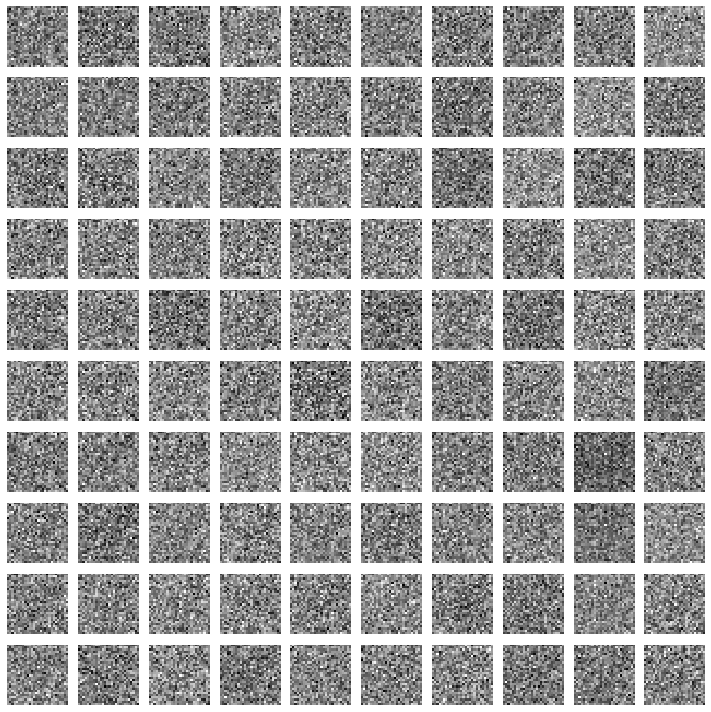

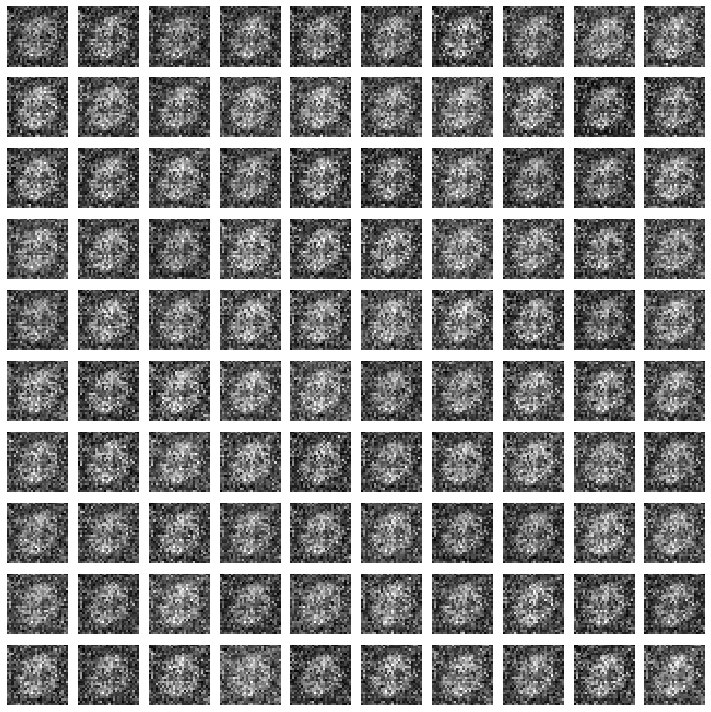

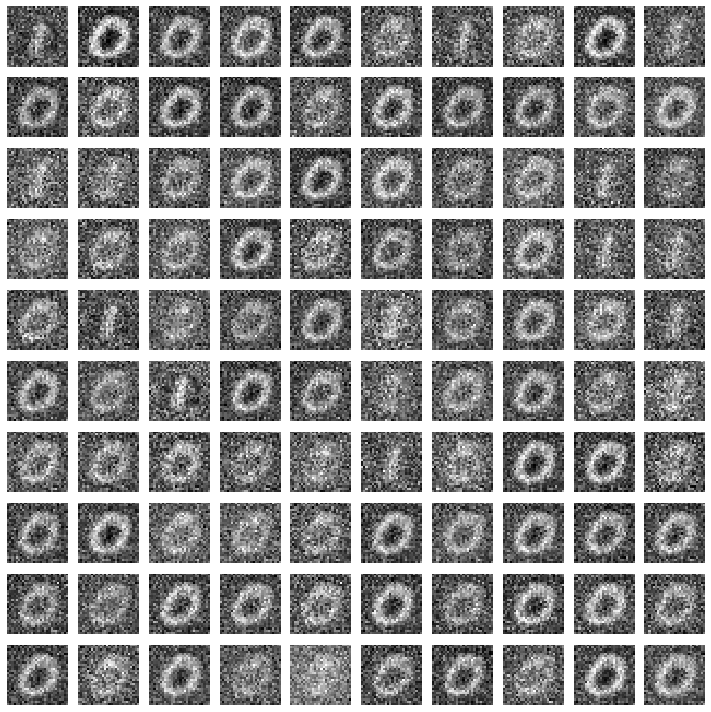

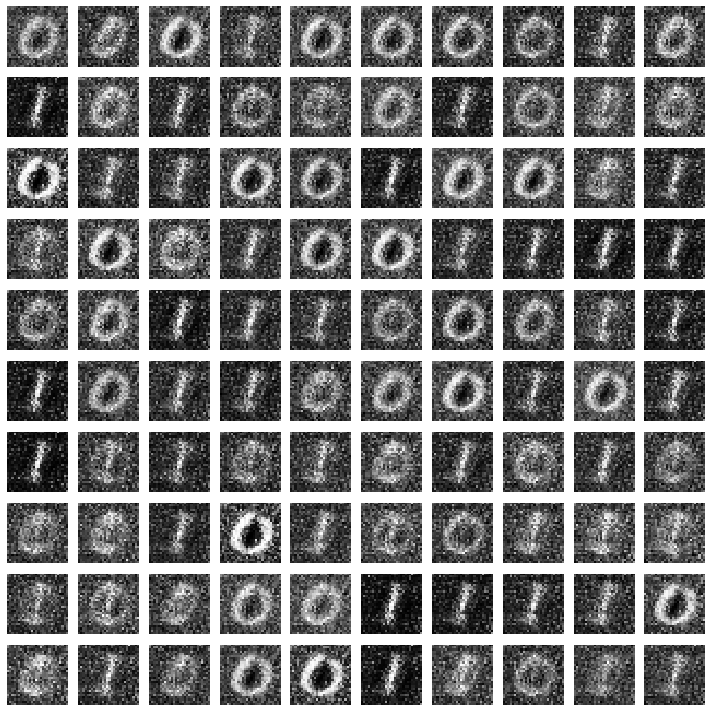

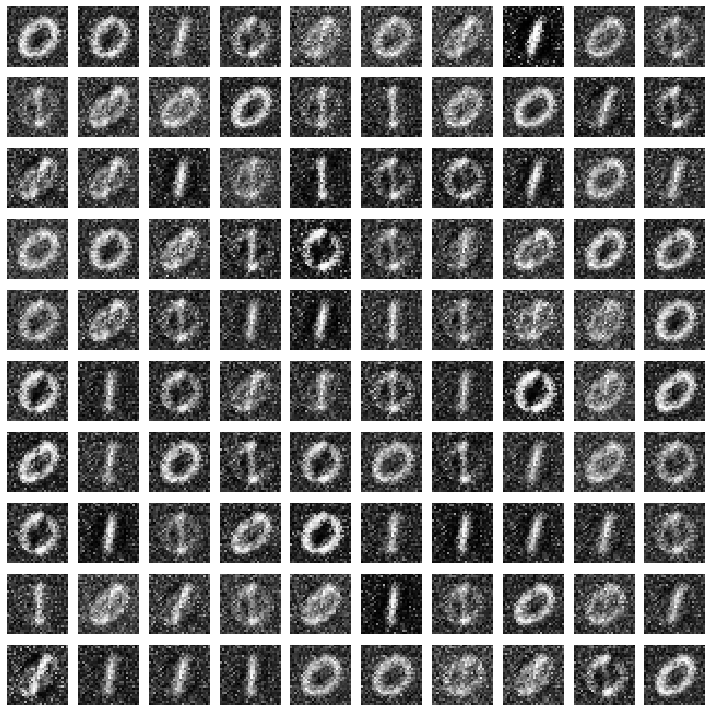

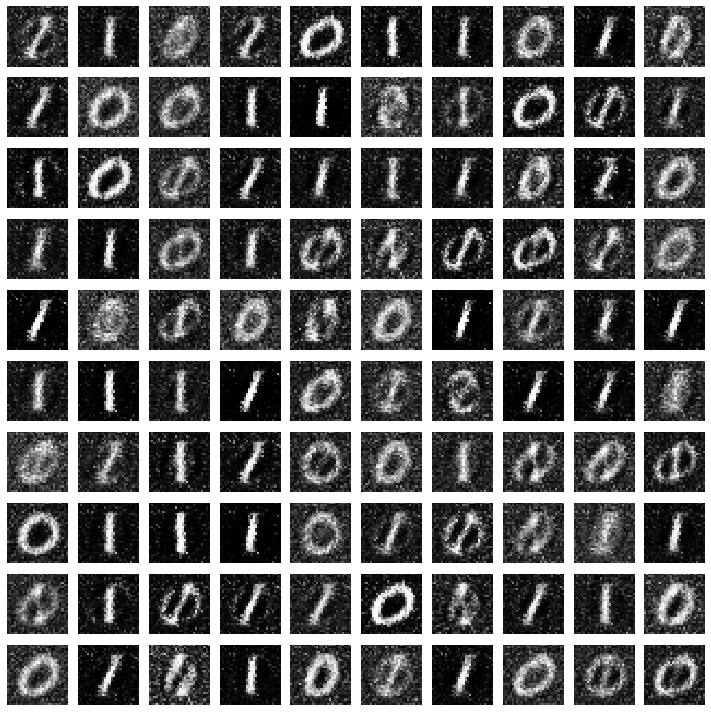

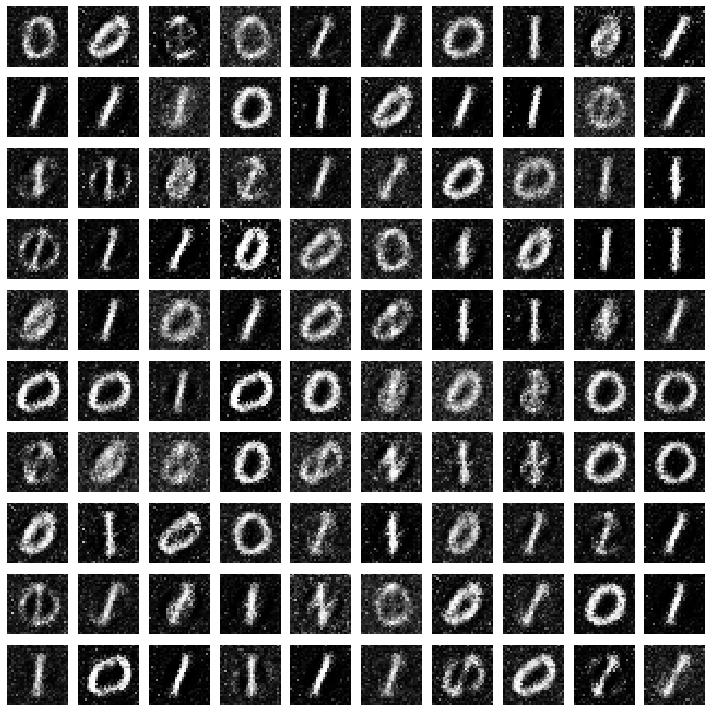

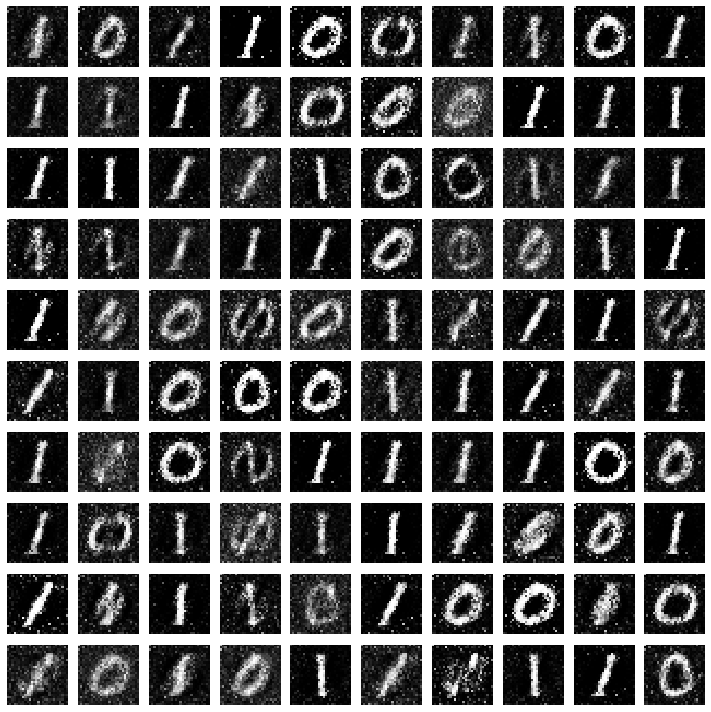

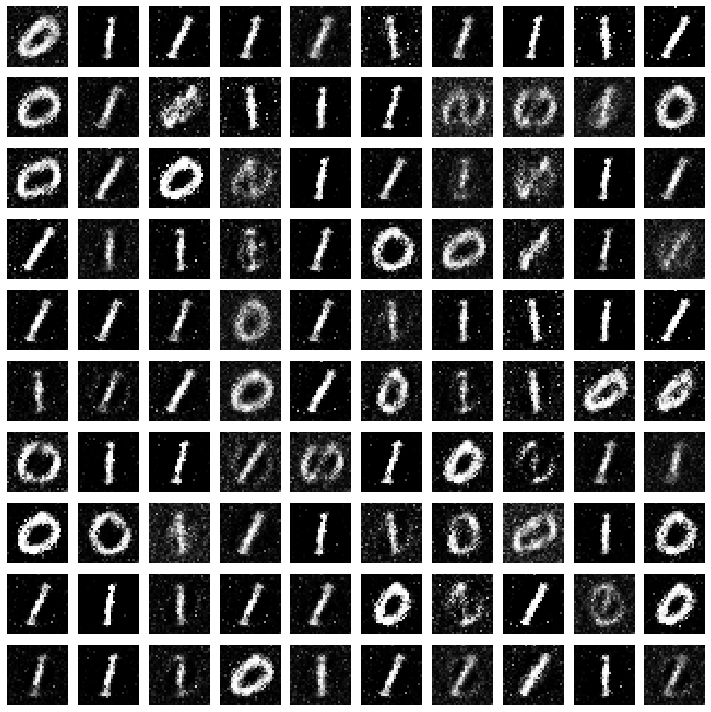

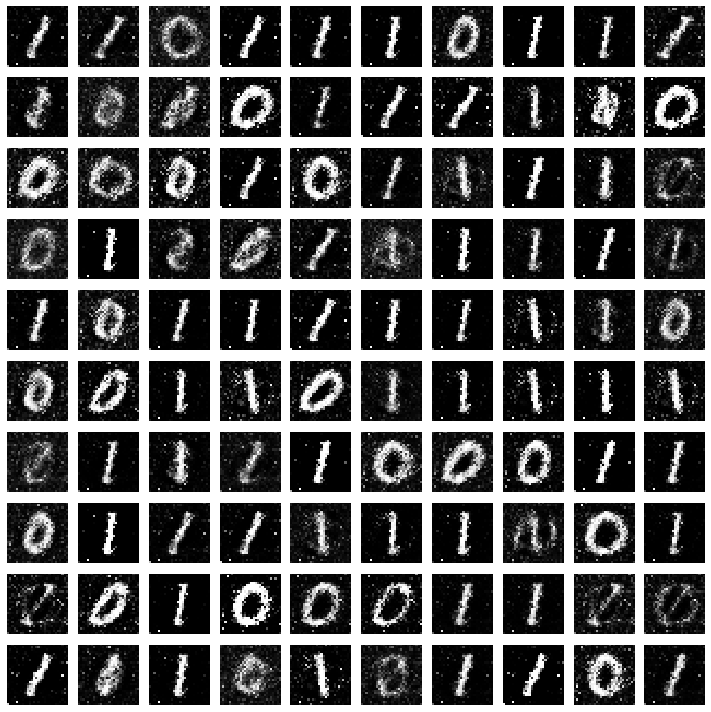

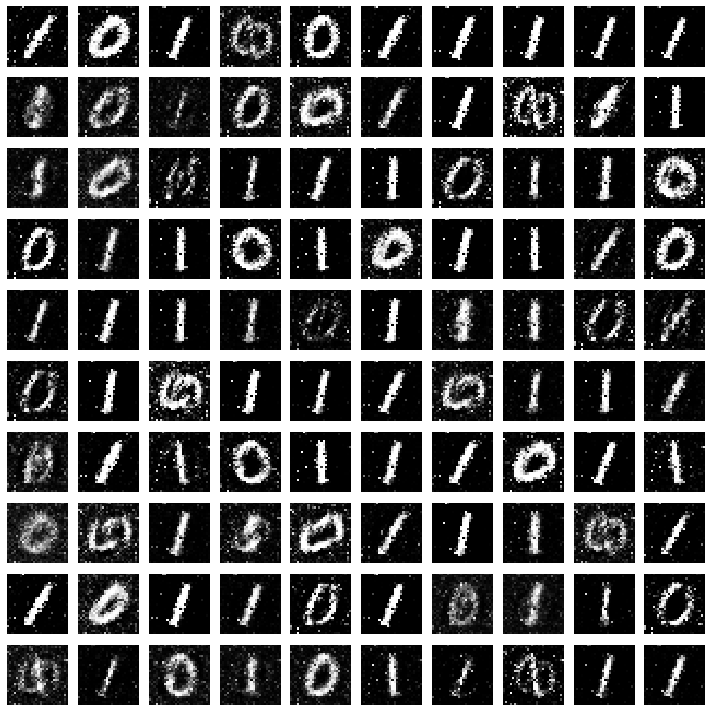

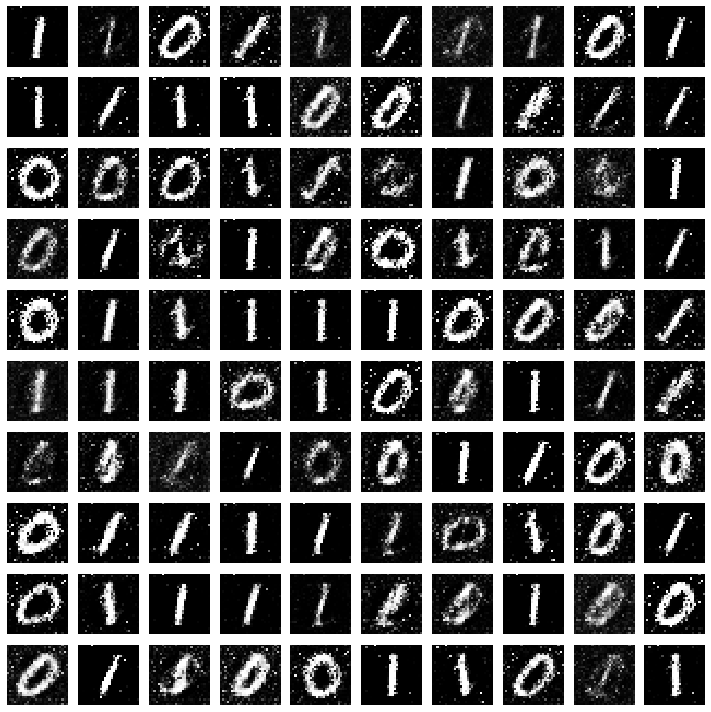

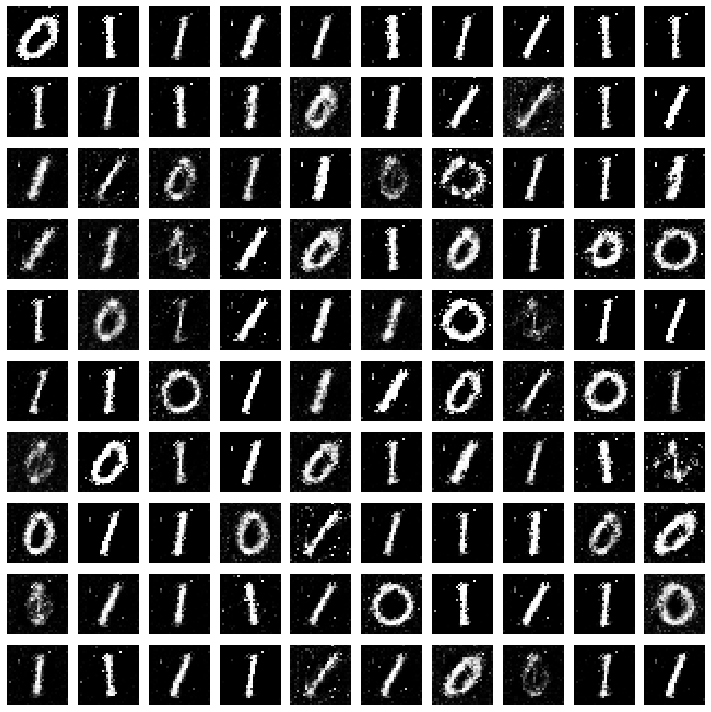

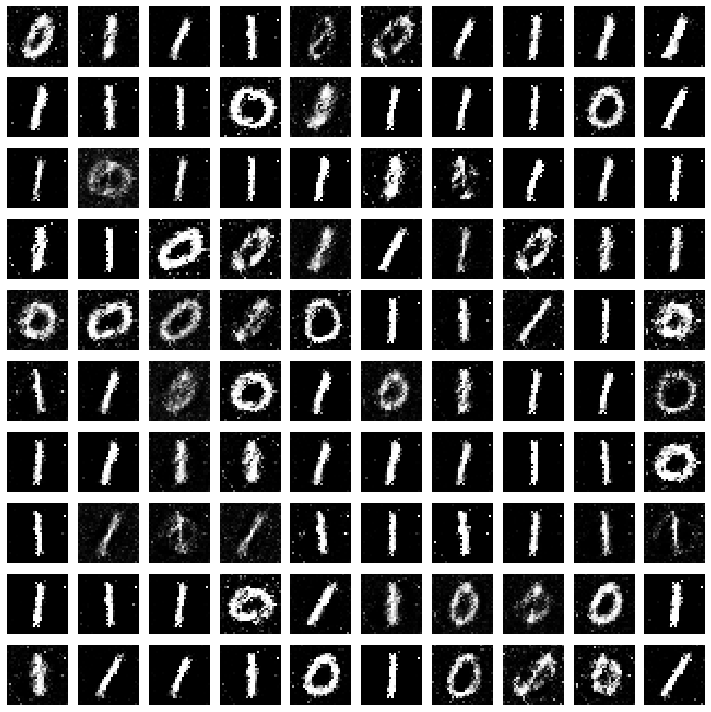

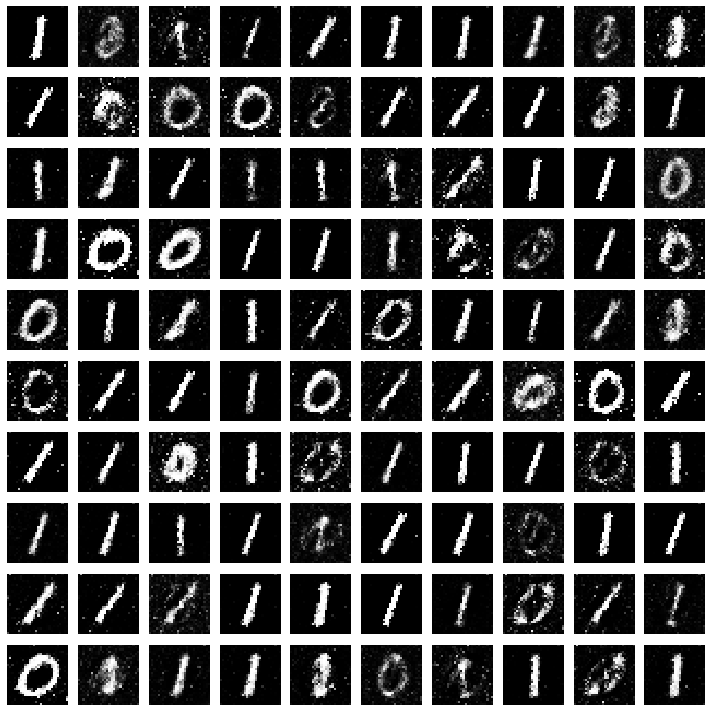

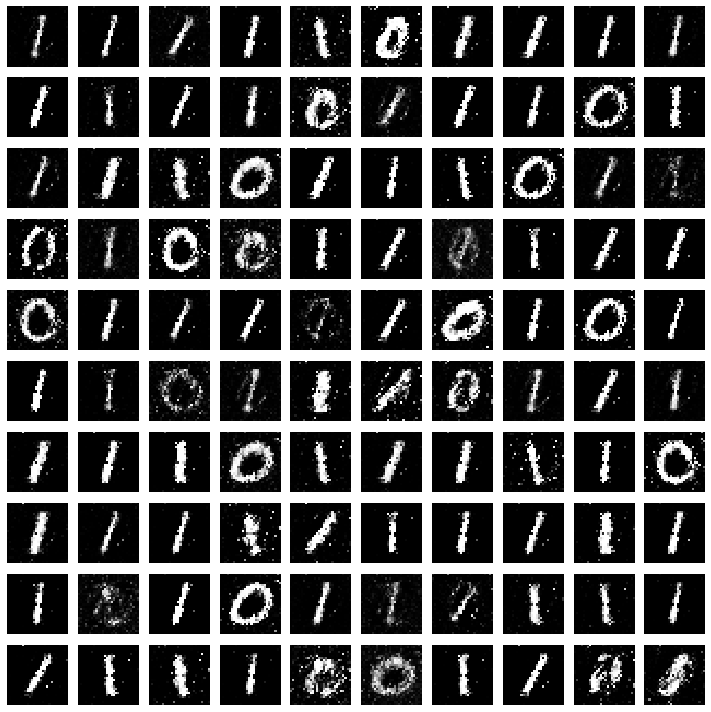

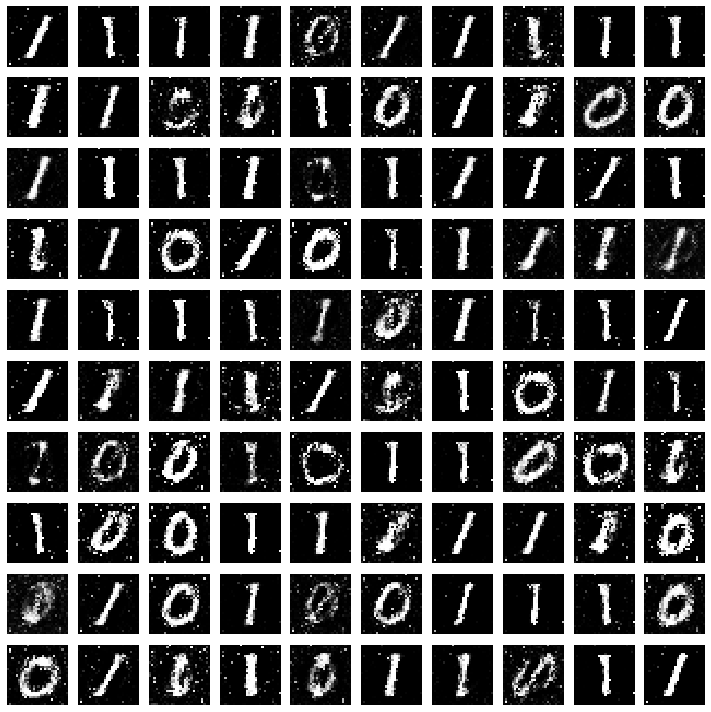

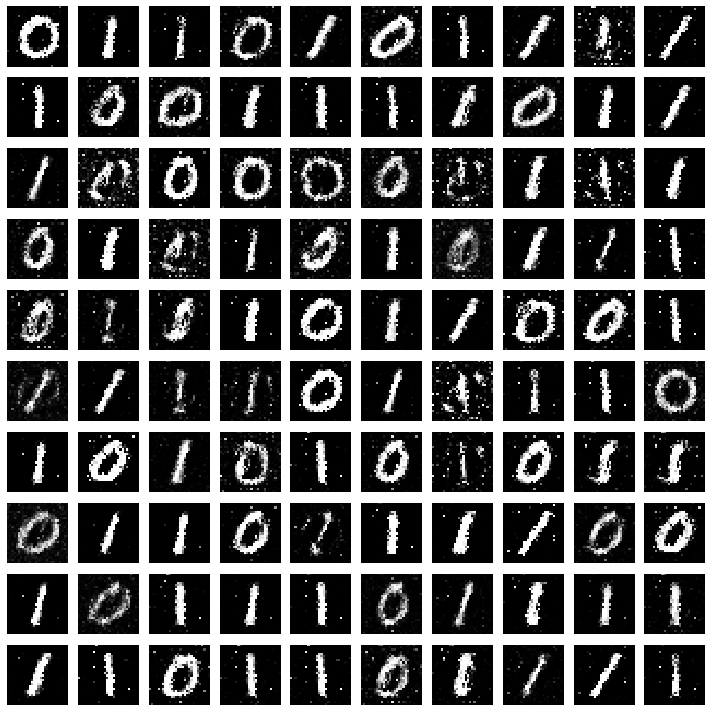

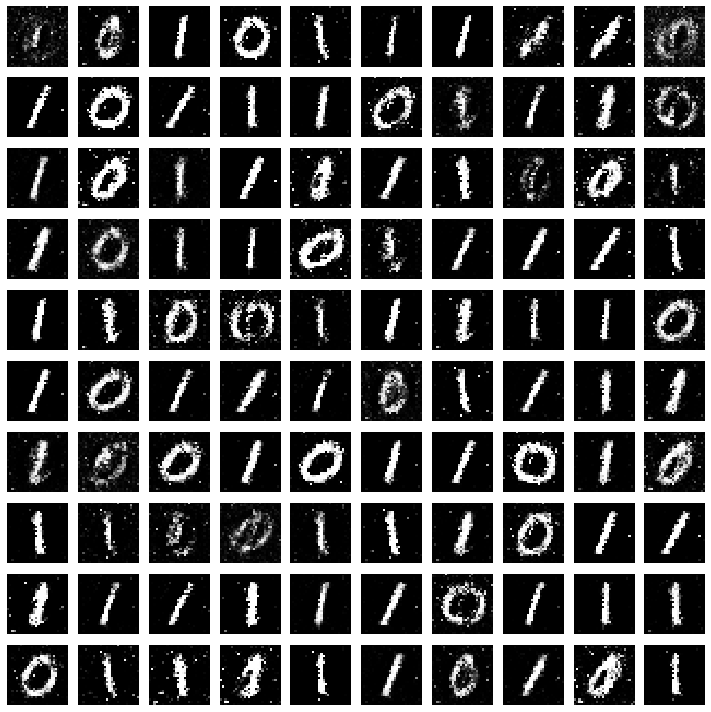

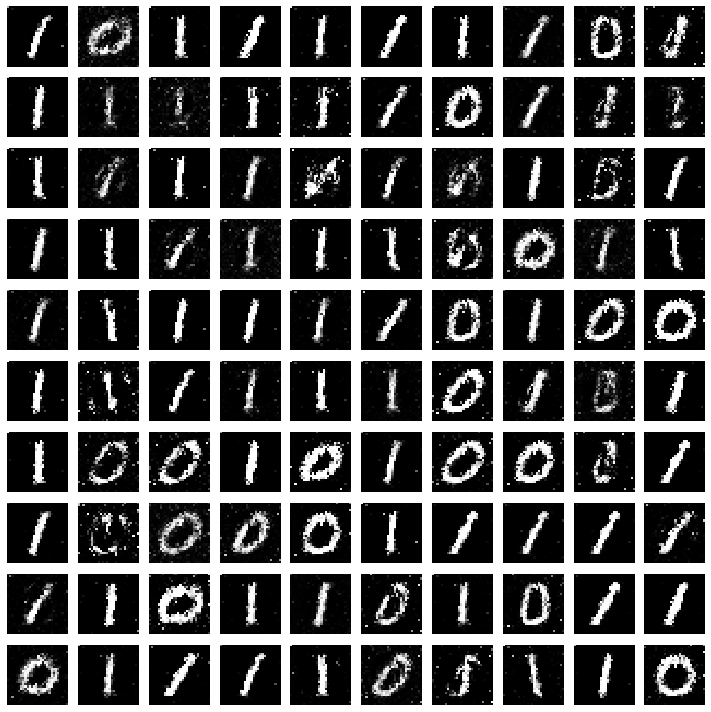

In [7]:
ganPlayerGD = training_gd(create_GAN_player, create_GAN_player)